# Spatial partitioning in Dask-GeoPandas

Dask-GeoPandas has implemented `spatial_shuffle` to repartition `Dask.GeoDataFrames`.
For those who are not familiar with Dask, a Dask DataFrame is internally split into many partitions, where each partition is a Pandas DataFrame.
Partitions are split vertically along the index; 

<img src="https://docs.dask.org/en/latest/_images/dask-dataframe.svg" alt="drawing" width="300"/>


Partitioning a Dask DataFrame avoids element-wise operations, where every possible candidate in a query is evaluated.
By evaluating less candidates, we reduce memory overhead and the time taken to execute a query.
Several common strategies to partition Dask DataFrames include using a fixed number of partitions or partitions based on a column.
Dask-GeoPandas partitions GeoDataFrames by taking advantage of their spatial structure.

In the rest of this notebook, we use an example dataset to describe how Dask-GeoPandas takes advantage of this spatial structure and some best practices.

In [1]:
import geopandas
import dask_geopandas
import matplotlib.pyplot as plt

/Users/tstatham/anaconda3/envs/gsoc/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


We first begin by reading a small example dataset as a GeoDataFrame.

In [2]:
path = geopandas.datasets.get_path("naturalearth_lowres")
gdf = geopandas.read_file(path)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


We can then transform the GeoDataFrame to a Dask one, with a fixed number of aribitrary partitions - this does not yet spatially partition a Dask-GeoDataFrame.
Note: we can also read (and export) parquet files in Dask-GeoPandas containing spatially partitioned data.

In [3]:
d_gdf = dask_geopandas.from_geopandas(gdf, npartitions=4)

By visualising the convex hull of each partition, we can get a feel for how the Dask-GeoDataFrame has been partitioned using the fixed number.
A useful spatial partitioning scheme is one that minimises the degree of spatial overlap between partitions. 
By default, the fixed number of partitions does a poor job of spatially partitioning our example data - there is a high degree of overlap between partitions.

In [4]:
d_gdf.calculate_spatial_partitions() # convex hull
d_gdf.spatial_partitions

0    POLYGON ((-68.14863 -55.61183, -68.63999 -55.5...
1    POLYGON ((18.46490 -29.04546, 16.34498 -28.576...
2    POLYGON ((166.74003 -22.39998, -8.89886 36.868...
3    POLYGON ((-180.00000 -90.00000, -180.00000 -84...
dtype: geometry

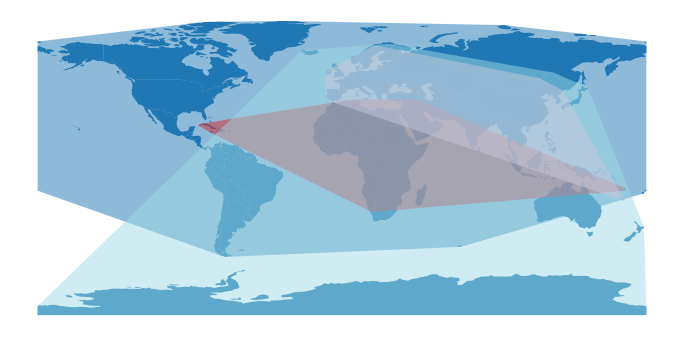

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf.plot(ax=ax)
d_gdf.spatial_partitions.plot(ax=ax, cmap="tab20", alpha=0.5)
ax.set_axis_off()
plt.show()

Spatially partitioning a Dask GeoDataFrames is done using `spatial_shuffle`, which is based on Dasks `set_index`.

spatial_shuffle supports three different partitioning methods, which provide an simple and inexpensive way of representing two-dimensional objects in one-dimensional space.
They are called using the `level` parameter;
1. Hilbert distance (default)
2. Morton distance
3. Geohash

The first two methods are [space-filling curves](https://en.wikipedia.org/wiki/Space-filling_curve), which are lines that pass through every point in space, in a particular order and pass through points once only, so that each point lies a unique distance along the curve.
The range of both curves contain the entire 2-dimensional unit square, which means that the hilbert and morton curve can handle projected coordinates.
In general, we recommend the default Hilbert distance because it has better order-preserving behaviour.
This is because the curve holds a remarkable mathematical property, where the distance between two consecutive points along the curve is always equal to one.
By contrast, the Morton distance or ["Z-order curve"](https://en.wikipedia.org/wiki/Z-order_curve) does not hold this property and there are larger "jumps" in distances between two consecutive points.

The Geohash, not to be confused with [geohashing](https://geohashing.site/geohashing/Main_Page) is a hierarchical spatial data structure, which subdivides space into buckets of grid shape.
Whilst the Geohash does allow binary searchers or spatial indexing, like rtree or quadtree, (a topic for later discussion & an enhancement for Dask-GeoPandas), Geohash is limited to encoding latitude and longitude coordinates.
The Geohash can be represented either as text string or integers, where the longer the string/integer is, the more precise the grid shape will be.

In [6]:
shuffled_d_gdf = d_gdf.spatial_shuffle(
    by="hilbert",
    level=16,
    calculate_partitions=True,
    npartitions=None,
    divisions=None,
    )
shuffled_d_gdf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
npartitions=4,,,,,,
375036506,int64,object,object,object,float64,geometry
2121788478,...,...,...,...,...,...
2331448094,...,...,...,...,...,...
2446126456,...,...,...,...,...,...
3764119180,...,...,...,...,...,...


Using the default parameters, the spatial shuffle does reduce the degree of spatial overlap between partitions but there is still considerable spatial overlap between partitions.

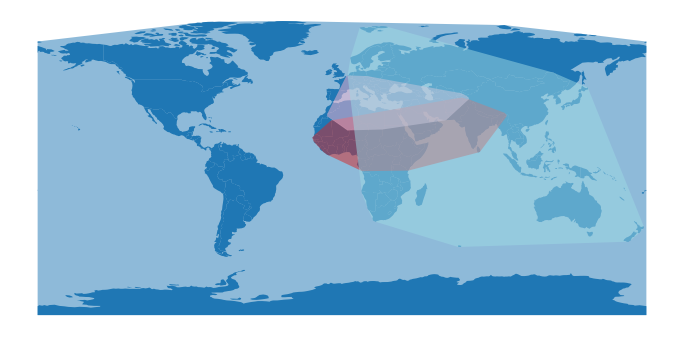

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf.plot(ax=ax)
shuffled_d_gdf.spatial_partitions.plot(ax=ax, cmap="tab20", alpha=0.5)
ax.set_axis_off()
plt.show()

## What precision?
The `level` parameter stands for the precision of each partitioning method.
The maximum precision is 16 for the Hilbert and Morton distance, whereas Geohash accepts a maximum precision 12.
We have found there are no significant penalties in selecting the maximum precision.

In [8]:
%timeit d_gdf.spatial_shuffle(by="hilbert", level=16, calculate_partitions=True, npartitions=None, divisions=None)

90.7 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit d_gdf.spatial_shuffle(by="morton", level=16, calculate_partitions=True, npartitions=None, divisions=None)

87.2 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit d_gdf.spatial_shuffle(by="geohash", level=12, calculate_partitions=True, npartitions=None, divisions=None)

83.8 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Below shows a comparison between each of the partitioning methods. 
With no partitions set (default), the same number of partitions of the input Dask GeoDataFrame is used.
Using the original number of partitions results in a high degree of spatial overlap between the partitions in all three methods.

In [11]:
hilbert = d_gdf.spatial_shuffle(by="hilbert", level=16, calculate_partitions=True, npartitions=None, divisions=None)
morton = d_gdf.spatial_shuffle(by="morton", level=12, calculate_partitions=True, npartitions=None, divisions=None)
geohash = d_gdf.spatial_shuffle(by="geohash", level=12, calculate_partitions=True, npartitions=None, divisions=None)

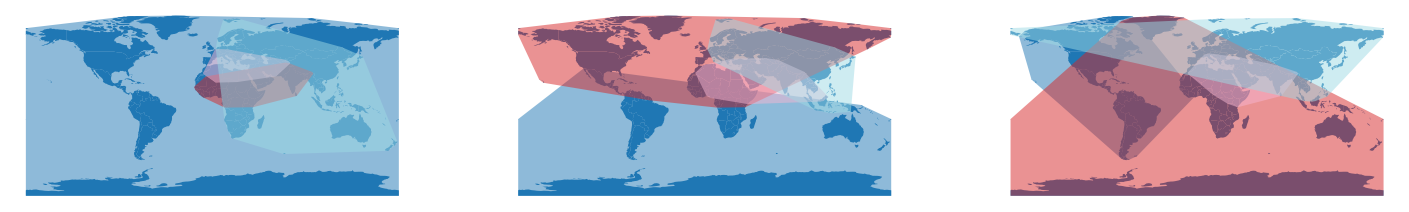

In [12]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(25,12))
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    gdf.plot(ax=ax)

hilbert.spatial_partitions.plot(ax=ax1, cmap="tab20", alpha=0.5)
morton.spatial_partitions.plot(ax=ax2, cmap="tab20", alpha=0.5)
geohash.spatial_partitions.plot(ax=ax3, cmap="tab20", alpha=0.5)

[axi.set_axis_off() for axi in axes.ravel()]
plt.show()

### How many partitions?
The number of partitions set is one of the most important parameters in controlling the behaviour of spatial partitioning but knowing how many partitions to set is tricky because there is no single answer.
The number of partitions depends not only on your data structure but also what you plan to do with your data.
Increasing the number of partitions from 4 to 10 partitions is more expensive to compute but does decrease the degree of spatial overlap between partitions.

In [13]:
npartitions = 10

In [14]:
%timeit d_gdf.spatial_shuffle(by="hilbert", level=16, calculate_partitions=True, npartitions=npartitions, divisions=None)

138 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit d_gdf.spatial_shuffle(by="morton", level=16, calculate_partitions=True, npartitions=npartitions, divisions=None)

141 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit d_gdf.spatial_shuffle(by="geohash", level=12, calculate_partitions=True, npartitions=npartitions, divisions=None)

140 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
hilbert10 = d_gdf.spatial_shuffle(by="hilbert", level=16, calculate_partitions=True, npartitions=npartitions, divisions=None)
morton10 = d_gdf.spatial_shuffle(by="morton", level=16, calculate_partitions=True, npartitions=npartitions, divisions=None)
geohash10 = d_gdf.spatial_shuffle(by="geohash", level=12, calculate_partitions=True, npartitions=npartitions, divisions=None)

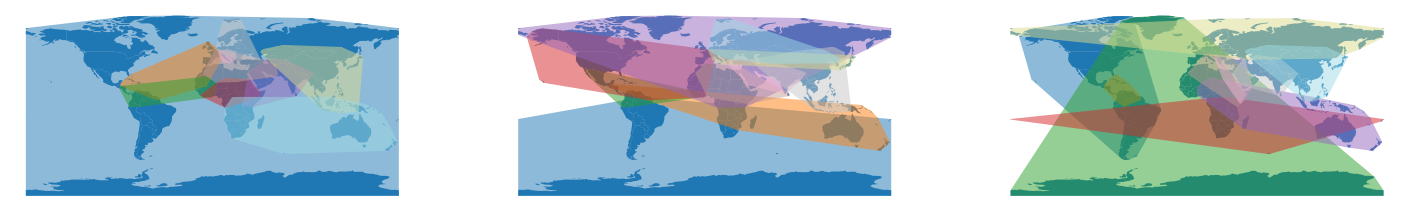

In [18]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(25,12))
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    gdf.plot(ax=ax)

hilbert10.spatial_partitions.plot(ax=ax1, cmap="tab20", alpha=0.5)
morton10.spatial_partitions.plot(ax=ax2, cmap="tab20", alpha=0.5)
geohash10.spatial_partitions.plot(ax=ax3, cmap="tab20", alpha=0.5)

[axi.set_axis_off() for axi in axes.ravel()]
plt.show()

## What about points?

In [19]:
import numpy as np
def _random_points(bounds, p):
    """Calculate p random points based on GeoDataFrame bounds"""
    return np.array(
        [
            np.random.uniform(bounds[0], bounds[2], p),
            np.random.uniform(bounds[1], bounds[3], p),
        ]
    ).T

In [20]:
import pandas as pd
n = 1_000_000
pts = pd.DataFrame(
    _random_points(gdf.total_bounds, n), 
    columns=["longitude", "latitude"]
)

In [21]:
gdf_pts = geopandas.GeoDataFrame(
    pts,
    geometry=geopandas.points_from_xy(
        pts.longitude, pts.latitude, crs=gdf.crs
    )
)
gdf_pts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype   
---  ------     --------------    -----   
 0   longitude  1000000 non-null  float64 
 1   latitude   1000000 non-null  float64 
 2   geometry   1000000 non-null  geometry
dtypes: float64(2), geometry(1)
memory usage: 22.9 MB


In [22]:
d_gdf_pts = dask_geopandas.from_geopandas(gdf_pts, npartitions=4)

In [23]:
pt_partitions = 100
hilbert_pts = d_gdf_pts.spatial_shuffle(by="hilbert", level=16, calculate_partitions=True, npartitions=pt_partitions, divisions=None)

Using spatial_shuffle on GeoDataFrames containing Point geometries yields a more uniform partitioning of space and less spatial overlap between partitions, when compared to polygons.
This is because distances along the curves are based on the mid points of geometries.
Whilst this is inexpensive, mid points do not represent complex geometries well.
Future work will examine various methods for better representating complex geometries.

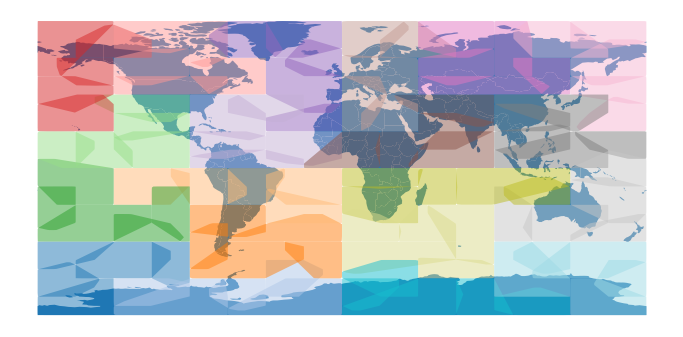

In [24]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf.plot(ax=ax)
hilbert_pts.spatial_partitions.plot(ax=ax, cmap="tab20", alpha=0.5)
ax.set_axis_off();

## Partitioning guidelines
Dask offers some guidance on partitioning Pandas DataFrames, which include;
1. If you your DataFrame fit easily into memory, than [Geo]Pandas can often be faster and easier to use than Dask[-GeoPandas] - so we always recommend trying GeoPandas first.
2. If you are running into memory and/or performance issues with [Geo]Pandas, then the number of partitions should fit comfortably in memory (each smaller than a gigabyte) - so if you are handling a 10GB dataset, then perhaps try using 10 partitions. 
3. If you are performing many tasks, where you increase/decrease the size of each DataFrame, it's useful to reconsider how many partitions you need. This may mean repartitioning your DataFrame again or using GeoPandas.
4. It may be that only a single component of your workflow does not fit into memory and we recommend using GeoPandas once this single component has been computed.

Dask offers [further guidance](https://docs.dask.org/en/latest/best-practices.html) on when/how to use partitioning.